In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

listings_df = pd.read_csv("/input/seattle/listings.csv", parse_dates =['host_since'])
calendar_df = pd.read_csv("/input/seattle/calendar.csv", parse_dates = ['date'])
reviews_df = pd.read_csv("/input/seattle/reviews.csv")

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# 1. Who are the hosts?

I find that there are 3 figure of the hosts on the airbnb:

1. "Entire home/apt" is the largest room type（67%） on the airbnb,followed by "private room" 
2. Long term hosts take up to 52% of the hosts
3. The number of "private room" and "shared room" hosts remain stable relative.
4. "share room" is almost avaiable all the year. 

Base on that we can make the assumption that:

1. About 31% of the host barely use there house, make it a home hotel. They provide almost 54.42% of all the accommodates.
2. About 18.62% of the host provide a spare bedroom and a bathroom for the guest.They provide almost 16.93% of the accommodates.
3. About 3% of the host provide a bedroom as shared room


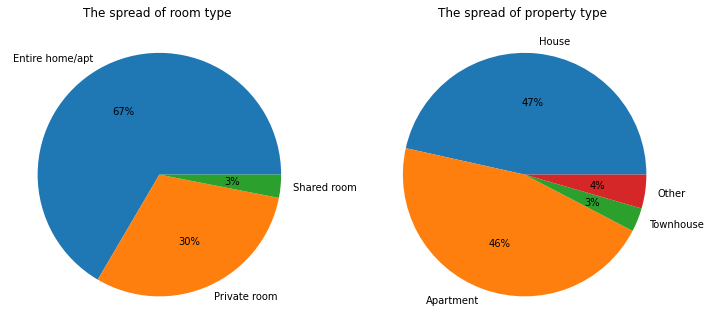

In [3]:
#listings_df['room_type'].pie()
room_type_count = listings_df['room_type'].value_counts()
property_type_count = listings_df['property_type'].value_counts()
property_type_count = property_type_count[:3].append(pd.Series(property_type_count[4:].sum(), index = ['Other']))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,12))
#plt.figsize(12,8)
fig.suptitle = "The spread of room and property type"
ax1.pie(room_type_count,labels = room_type_count.index, autopct='%1.0f%%')
ax1.set_title("The spread of room type ")
ax2.pie(property_type_count,labels = property_type_count.index,autopct='%1.0f%%')
ax2.set_title("The spread of property type ")

#ax2.title("The spread of the type of room")
fig.show()

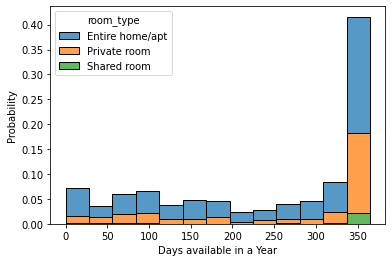

In [4]:
ax_avail = sns.histplot(listings_df[['availability_365','room_type']],\
             x = 'availability_365',\
             hue = 'room_type',\
            multiple = 'stack',\
                       stat = 'probability')
ax_avail.set(xlabel = "Days available in a Year")
plt.show()

The price is what were care most ,let see how the spread of the price

In [5]:
listings_df[listings_df['room_type'] == 'Shared room']['availability_365'].mean()

entire_300host_list = ((listings_df['room_type'] == 'Entire home/apt') & (listings_df['availability_365'] > 300))
entire_300host_pct = entire_300host_list.sum()/listings_df.shape[0]

entire_300host_acc = (listings_df[entire_300host_list]['availability_365']*listings_df[entire_300host_list]['accommodates']).sum()
all_acc = (listings_df['availability_365']*listings_df['accommodates']).sum()
entire_300host_acc_pct = entire_300host_acc/all_acc
print(entire_300host_pct,entire_300host_acc_pct)

private_300host_list = ((listings_df['room_type'] == 'Private room') & (listings_df['availability_365'] > 300))
private_300host_pct = private_300host_list.sum()/listings_df.shape[0]
private_300host_acc = (listings_df[private_300host_list]['availability_365']*listings_df[private_300host_list]['accommodates']).sum()
private_300host_acc_pct = private_300host_acc/all_acc
#listings_df[(listings_df['room_type'] == 'Entire home/apt') and (listing_df['availability_365'] > 300)].shape
#listings_df[listings_df['room_type'] == 'Shared room']['availability_365'].quantile(0.2)


0.3122053431115767 0.5441693742145101


In [6]:
cal_df_dropna = calendar_df.dropna()
cal_avail_m = cal_df_dropna.merge(listings_df[['id','room_type']], left_on= 'listing_id', right_on = 'id')
cal_avail_m = cal_avail_m.groupby(['date','room_type'])['available'].count().reset_index()

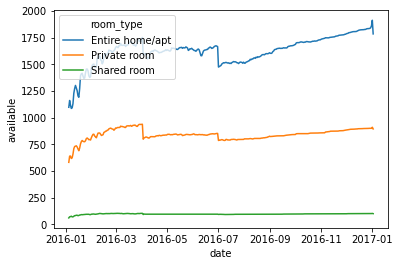

In [7]:

sns.lineplot(x = cal_avail_m['date'], y = cal_avail_m['available'], hue = cal_avail_m['room_type'])
plt.show()

In [8]:
listings_df[['price','cleaning_fee','extra_people']] = listings_df[['price','cleaning_fee','extra_people']].fillna(0)
listings_df[['price','cleaning_fee','extra_people']] = listings_df[['price','cleaning_fee','extra_people']].replace({"\$": ""}, regex = True)
listings_df[['price','cleaning_fee','extra_people']] = listings_df[['price','cleaning_fee','extra_people']].replace({"\,": ""}, regex = True)
listings_df[['price','cleaning_fee','extra_people']] = listings_df[['price','cleaning_fee','extra_people']].replace({"\.00": ""}, regex = True)
listings_df[['price','cleaning_fee','extra_people']] = listings_df[['price','cleaning_fee','extra_people']].astype("int")
listings_df['price_peracc'] = listings_df['price']/listings_df['accommodates']

# 2. Who are the guest?

we focuse on the hosts that recieved more then 7 reviews, which suggest that these hosts are more favored by the guests.

1. The overall price on the airbnb is low, the guest are more price sensitive.
2. Single guest take up to 5%, couple guest take up to 20%, couple with a child  take up 

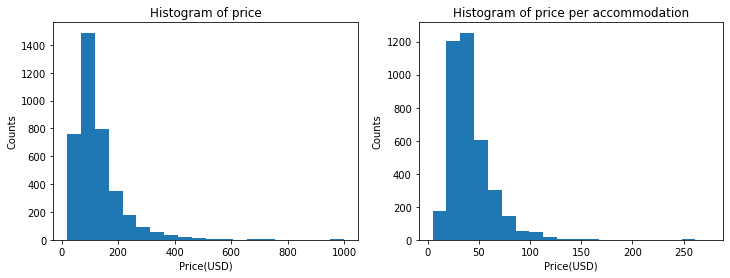

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,4))
ax1.hist(listings_df['price'],bins = 20)
ax1.set_title("Histogram of price")
ax1.set_xlabel("Price(USD)")
ax1.set_ylabel("Counts")
ax2.hist(listings_df['price_peracc'],bins =20)
ax2.set_title("Histogram of price per accommodation")
ax2.set_xlabel("Price(USD)")
ax2.set_ylabel("Counts")
fig.show()

In [10]:
print('The mean price is {}, the highest price is {}, the standard deviaton is {}'\
      .format(round(listings_df['price'].mean(),2),\
              listings_df['price'].max(),\
             round(listings_df['price'].std(), 2)))

print('The mean price per accommodation is {}, the highest price is {}, the standard deviaton is {}'\
      .format(round(listings_df['price_peracc'].mean(),2),\
              listings_df['price_peracc'].max(),\
             round(listings_df['price_peracc'].std(),2)))

The mean price is 127.98, the highest price is 1000, the standard deviaton is 90.25
The mean price per accommodation is 41.27, the highest price is 275.0, the standard deviaton is 20.68


In [11]:
review_5_list = listings_df['number_of_reviews'] >= 3
listings_review5 = listings_df[review_5_list]
listings_reivew_5_df = listings_review5[['bedrooms', 'bathrooms', 'accommodates','price_peracc']]


In [12]:
accommodates_count = listings_reivew_5_df['accommodates'].value_counts()
bedroom_count = listings_reivew_5_df['bedrooms'].value_counts()
bedroom_count_name = list(map(int, bedroom_count.index.to_list()))
bedroom_count.index = bedroom_count_name
bedroom_count.name = "Bedrooms"
bedroom_count = bedroom_count[:3].append(pd.Series(bedroom_count[4:7].sum(), index = [">3"]))
accommodates_count = accommodates_count[:5].append(pd.Series(accommodates_count[6:].sum(), index = [">6"]))
accommodates_count.name = "accommodates"

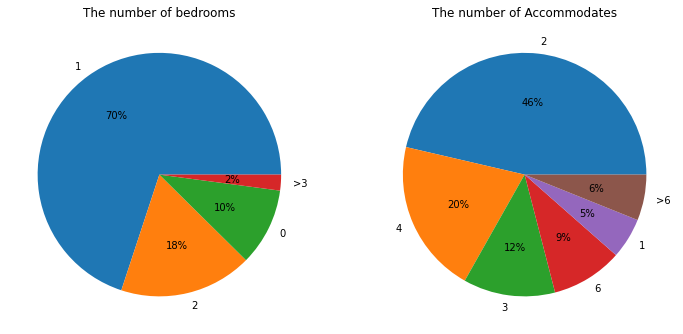

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,12))
ax1.pie(bedroom_count, labels = bedroom_count.index, autopct = '%1.0f%%')
ax1.set_title("The number of bedrooms")
ax2.pie(accommodates_count, labels = accommodates_count.index, autopct = '%1.0f%%')
ax2.set_title("The number of Accommodates")
fig.show()

# 3. What does the Guest care about?

As we dig further, we want to know what do the guests care most:

1. value, cleanliness , accuracy are the top 3 relevant to score rating.
2. "Bungalow" is the kind of property with the hightest ratings, althought "dorm" and "tent" have higher coef value ,but the number is too small.
3. neighbourhood like "Laurelhurst" and "Yesler Terrace" tend to have higher value rating
4. "Pull-out Sofa" has the highest value rating ,while "Real Bed" is at the fourth place. People seems dont care too much about bed type.
5. "Smoke allowed " and "pets" are the two most welcome amenities.

We can see that the property type and neighbourhood is the most important for the guest. but all the hardware of the house seem cant explain the rating value.

So as I assume that the decoration and feel of the house is most important for the guest.

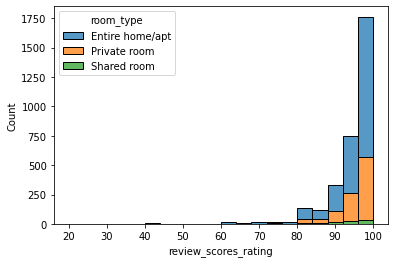

In [14]:
sns.histplot(listings_df[['review_scores_rating','room_type']],\
             x = 'review_scores_rating',\
            hue = 'room_type',\
             bins = 20,\
            multiple = 'stack')
plt.show()



In [15]:
review_scores_df = listings_df.loc[:,listings_df.columns.str.contains('review')].copy()
review_scores_df.dropna(how = 'all', inplace = True)
review_scores_df.describe()
review_scores_df_drop = review_scores_df.dropna(axis = 0)

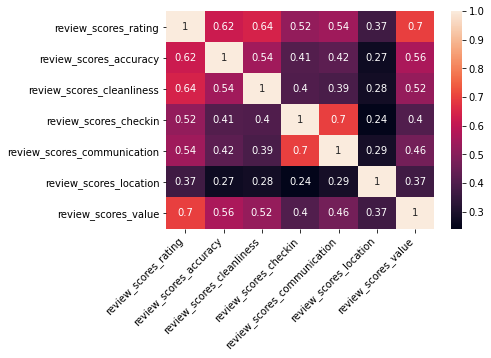

review_scores_rating           1.000000
review_scores_value            0.696288
review_scores_cleanliness      0.642380
review_scores_accuracy         0.622438
review_scores_communication    0.543626
review_scores_checkin          0.521914
review_scores_location         0.368714
Name: review_scores_rating, dtype: float64


In [16]:
review_corr = review_scores_df_drop.drop(['reviews_per_month','number_of_reviews'], axis = 1).corr()
sns.heatmap(review_corr, annot = True)
plt.xticks(rotation = 45,ha = 'right')
plt.show()
print(review_corr['review_scores_rating'].sort_values(ascending = False))

In [17]:
listings_df['amenities'] = listings_df['amenities'].str.replace("{|}|\"|\'", "", regex = True)

We try to fit review_scores_value into a linearregression model, and find out what affects review score on value most.

In [18]:
value_num_list =['review_scores_value', 'accommodates', 'bedrooms','availability_365' ,'bathrooms', 'beds','price', 'guests_included', 'cleaning_fee' ,'extra_people','minimum_nights','maximum_nights']
value_cat_list = ['property_type','room_type', 'neighbourhood_cleansed','bed_type', 'host_is_superhost', 'host_identity_verified']

value_df = listings_df[value_num_list + value_cat_list + ['amenities']].copy()
value_df.dropna(subset = ['review_scores_value'] ,axis = 0, inplace = True)

y = value_df['review_scores_value'].copy()
for col in value_num_list:
    value_df[col].fillna(0, inplace = True)
for col in value_cat_list:
    value_df = pd.concat([value_df.drop(col, axis =1), pd.get_dummies(value_df[col], prefix = col, prefix_sep = "__", drop_first = True, dummy_na = True )], axis = 1)

amenities_dummies = value_df['amenities'].str.get_dummies(sep = ',')
amenities_dummies.columns = "amenities__"+amenities_dummies.columns
X = pd.concat([value_df.drop('amenities', axis =1),amenities_dummies], axis = 1).drop('review_scores_value' ,axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3,random_state= 42)

In [19]:

model = LinearRegression()
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
coef = pd.DataFrame({"X":X_train.columns.str.split("__"), "coef":model.coef_ })
coef['coef_abs'] = coef['coef'].abs()
coef['X_group']= coef['X'].apply(lambda x:x[0])
coef['X_sub'] = coef['X'].apply(lambda x:x[-1])

group_name_list = coef['X_group'].unique()

coef_top5 = pd.DataFrame()
for var in group_name_list:
    coef_top5 = coef_top5.append(coef[coef['X_group'] == var].sort_values("coef_abs",ascending = False)[:4])
coef_top5 =coef_top5.sort_values("coef_abs", ascending = False)    

coef_top20 = coef_top5[['X_group', 'X_sub', 'coef', 'coef_abs']].head(20)
print(coef_top20)

0.18131850610943867
0.05930763481542545
                    X_group                 X_sub      coef  coef_abs
18            property_type                  Dorm  0.671028  0.671028
64   neighbourhood_cleansed           Laurelhurst  0.631926  0.631926
115  neighbourhood_cleansed        Yesler Terrace  0.617212  0.617212
93   neighbourhood_cleansed             Riverview -0.573326  0.573326
101  neighbourhood_cleansed            South Park -0.520179  0.520179
119                bed_type         Pull-out Sofa  0.477122  0.477122
117                bed_type                 Couch  0.422522  0.422522
22            property_type                  Tent  0.408138  0.408138
118                bed_type                 Futon  0.401420  0.401420
15            property_type             Camper/RV -0.381045  0.381045
122       host_is_superhost                     t  0.324547  0.324547
120                bed_type              Real Bed  0.304313  0.304313
13            property_type              Bungalow 

The model accuracy isnot good enough, but we can still find some usefull information.